In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

plt.style.use('ggplot')

mpl.rcParams['axes.unicode_minus'] = False

In [2]:
train = pd.read_csv('./train.csv', parse_dates=["datetime"])
train.shape

(10886, 12)

In [3]:
test = pd.read_csv('./test.csv', parse_dates=["datetime"])
test.shape

(6493, 9)

## Feature Engineering

In [4]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 16)

In [5]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['hour'] = test['datetime'].dt.hour
test['dayofweek'] = test['datetime'].dt.dayofweek
test.shape

(6493, 13)

## Feature Selection

In [9]:
categorical_feature_names = ['season', 'holiday', 'workingday', 'weather', 'dayofweek', 'month', 'year', 'hour']

for var in categorical_feature_names:
    train[var] = train[var].astype('category')
    test[var] = test[var].astype('category')

In [10]:
feature_names = ['season', 'weather', 'temp', 'atemp', 'humidity',
                'year', 'hour', 'dayofweek', 'holiday', 'workingday']
feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [11]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,2011,0,5,0,0
1,1,1,9.02,13.635,80,2011,1,5,0,0
2,1,1,9.02,13.635,80,2011,2,5,0,0
3,1,1,9.84,14.395,75,2011,3,5,0,0
4,1,1,9.84,14.395,75,2011,4,5,0,0


In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   weather     10886 non-null  category
 2   temp        10886 non-null  float64 
 3   atemp       10886 non-null  float64 
 4   humidity    10886 non-null  int64   
 5   year        10886 non-null  category
 6   hour        10886 non-null  category
 7   dayofweek   10886 non-null  category
 8   holiday     10886 non-null  category
 9   workingday  10886 non-null  category
dtypes: category(7), float64(2), int64(1)
memory usage: 331.5 KB


In [13]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,2011,0,3,0,1
1,1,1,10.66,13.635,56,2011,1,3,0,1
2,1,1,10.66,13.635,56,2011,2,3,0,1
3,1,1,10.66,12.880,56,2011,3,3,0,1
4,1,1,10.66,12.880,56,2011,4,3,0,1


In [14]:
label_name = "count"
y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

## Score

### RMSLE

In [21]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):
    if convertExp:
        predicted_values = np.exp(predicted_values)
        actual_values = np.exp(actual_values)
        
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    difference = np.log(predicted_values+1)-np.log(actual_values+1)
    difference = np.square(difference)
    score = np.sqrt(difference.mean())
    
    return score

### Linear Regression Model

In [24]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

pd.options.mode.chained_assignment = None

# initialize
lModel = LinearRegression()

# training
y_train_log = np.log1p(y_train)
lModel.fit(X_train, y_train_log)

# predcition and accuracy
preds = lModel.predict(X_train)
print("RMSLE Value For Linear Regression: {:.5f}".format(rmsle(np.exp(y_train_log), np.exp(preds), False)))

RMSLE Value For Linear Regression: 0.98037


## Regularization Model - Ridge
    • Linear Regression Model for recurrent
    • limit forced overfitting

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9803697902780802


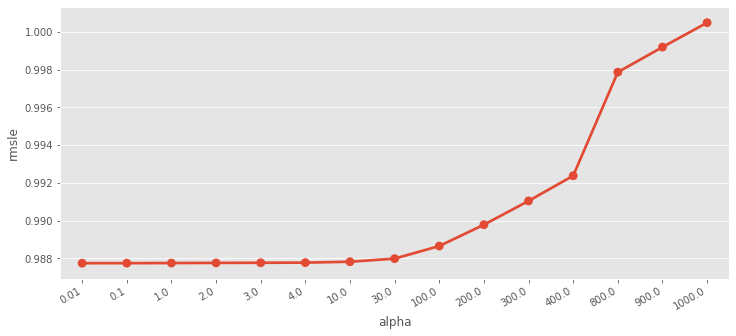

In [36]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)

y_train_log = np.log1p(y_train)
grid_ridge_m.fit( X_train, y_train_log )
preds = grid_ridge_m.predict(X_train)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_train_log),np.exp(preds), False))

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)

df = pd.DataFrame(grid_ridge_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)

plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df, x='alpha', y='rmsle', ax=ax)

## Regularization Model - Lasso

{'alpha': 0.00125, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9803727821457646


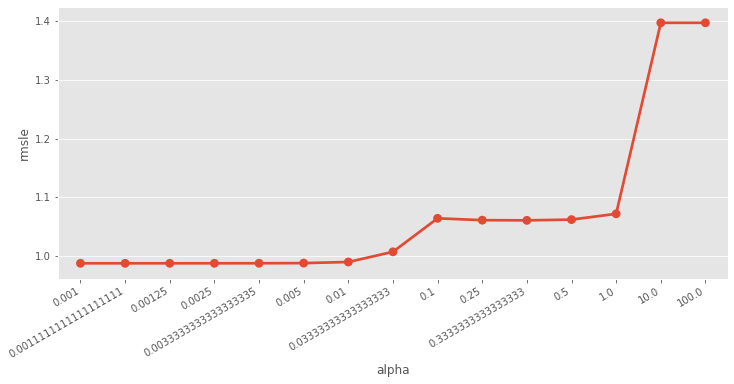

In [38]:
lasso_m_ = Lasso()
alpha = 1/np.array([0.01, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = {'max_iter':[3000], 'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,
                          lasso_params_,
                          scoring = rmsle_scorer,
                          cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m.fit( X_train, y_train_log )
preds = grid_lasso_m.predict(X_train)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_train_log),np.exp(preds), False))

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)

df = pd.DataFrame(grid_lasso_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)

plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df, x='alpha', y='rmsle', ax=ax)


## Ensemble Models - Random Forest

RMSLE Value for Random Forest: 0.10741


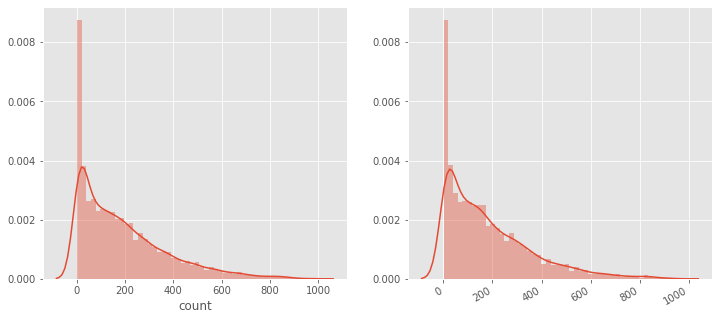

In [44]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)

preds = rfModel.predict(X_train)
score = rmsle(np.exp(y_train_log), np.exp(preds), False)
print("RMSLE Value for Random Forest: {:.5f}".format(score))

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)

plt.xticks(rotation=30, ha='right')
sns.distplot(y_train, ax=ax1, bins=50)

plt.xticks(rotation=30, ha='right')
sns.distplot(np.exp(rfModel.predict(X_test)), ax=ax2, bins=50)

## Submit

In [46]:
submission = pd.read_csv('./sampleSubmission.csv')
submission

submission['count'] = np.exp(rfModel.predict(X_test))

submission.head()
                         

,datetime,count
0,2011-01-20 00:00:00,12.273176
1,2011-01-20 01:00:00,5.490063
2,2011-01-20 02:00:00,4.443423
3,2011-01-20 03:00:00,4.889555
4,2011-01-20 04:00:00,3.832388


In [47]:
submission.to_csv('./Score_{0:.5f}_submission.csv'.format(score), index=False)

In [48]:
# score : 0.39907
218/3242

0.06724244293645898

## Ensemble Model - Gradient Boost

RMSLE Value For Gradient Boost:  0.21357403727249372


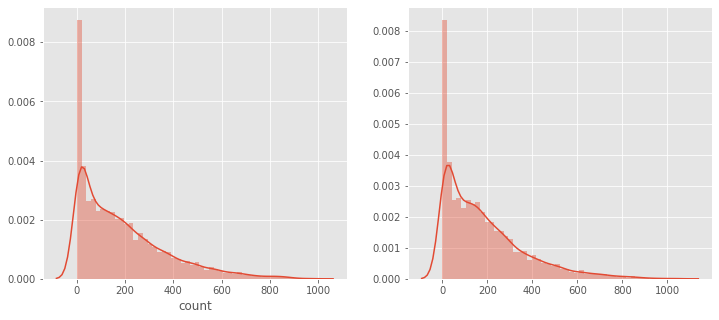

In [49]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Gradient Boost: ", score)

predsTest = gbm.predict(X_test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)

## Submit

In [51]:
submission = pd.read_csv("./sampleSubmission.csv")
submission

submission["count"] = np.exp(predsTest)

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,11.227543
1,2011-01-20 01:00:00,6.296610
2,2011-01-20 02:00:00,4.259238
3,2011-01-20 03:00:00,2.666615
4,2011-01-20 04:00:00,2.295918


In [52]:
submission.to_csv(f"./Score_{score:.5f}_submission.csv", index=False)

In [53]:
# score : 0.38657
144/3251

0.04429406336511842

In [54]:
submission.tail()

,datetime,count
6488,2012-12-31 19:00:00,227.341478
6489,2012-12-31 20:00:00,148.119611
6490,2012-12-31 21:00:00,102.384524
6491,2012-12-31 22:00:00,76.595049
6492,2012-12-31 23:00:00,39.552921
